In [253]:
import yfinance as yf
import pandas as pd

# OBX = the 25 most liquid stocks 

start_date = pd.Timestamp('2006-01-01')
end_date = pd.Timestamp('2010-01-01')

obx = yf.Ticker("OBX.OL")
obx_data = obx.history(start=start_date, end=end_date)

In [254]:
from pathlib import Path
import torch
import os

base_dir = Path(os.getcwd()).parent

df = pd.read_csv(base_dir / 'data' / 'all_articles_with_sentiment.csv')

In [255]:
#df = df[df['paper'] == 'vg']
df = df[df['paper'] != 'dn']
df = df[df['paper'] != 'da']
df = df[df['paper'] != 'db']

In [256]:
df['date'] = pd.to_datetime(df['date'], format='%y-%m-%d', errors='coerce')
df = df.dropna(subset=['date']) # remove invalid dates

df['score'] = df['score'].apply(
    lambda x: eval(x.replace("device='cuda:0'", ""), {"tensor": torch.tensor}) if isinstance(x, str) else x
)
df['score'] = df['score'].apply(lambda x: x.cpu() if isinstance(x, torch.Tensor) else x)

In [257]:
df = df[(df['date'] >= start_date) & (df['date'] <= end_date)] # filter out dates

In [258]:
weight_factor = 7.5
df['score'] = df['score'].apply(lambda x: x * weight_factor if x < 0 else x)

In [259]:
"""factor = 0.25
df['score'] = df['score'].apply(lambda x: x - factor if x < 0 else x)"""

"factor = 0.25\ndf['score'] = df['score'].apply(lambda x: x - factor if x < 0 else x)"

In [260]:
avg_sentiment = df.groupby('date')['score'].mean().reset_index() # average sentiment score for each date
avg_sentiment = avg_sentiment.sort_values(by='date') # sort by date

In [261]:
avg_sentiment['cumulative'] = avg_sentiment['score'].cumsum()

In [262]:
sentiment_offset = (obx_data['Close'].iloc[0] - avg_sentiment['cumulative'].iloc[0])
avg_sentiment['adjusted_cumulative'] = avg_sentiment['cumulative'] + sentiment_offset

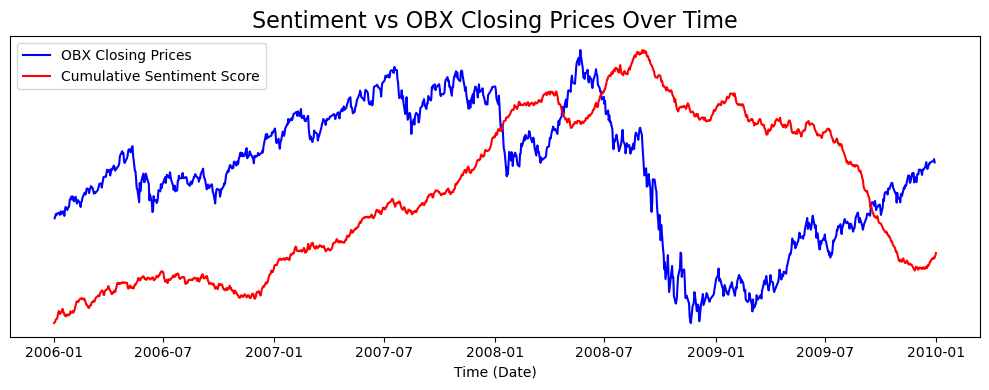

In [263]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#avg_sentiment['offset_date'] = avg_sentiment['date'] + pd.DateOffset(months=-3)

obx_data['normalized_close'] = scaler.fit_transform(obx_data[['Close']])
avg_sentiment['normalized_cumulative'] = scaler.fit_transform(avg_sentiment[['adjusted_cumulative']])

plt.figure(figsize=(10, 4))
plt.plot(obx_data['normalized_close'], label='OBX Closing Prices', color='blue')
plt.plot(avg_sentiment['date'], avg_sentiment['normalized_cumulative'], label='Cumulative Sentiment Score', color='red')
#plt.plot(avg_sentiment['offset_date'], avg_sentiment['normalized_cumulative'], label='Cumulative Sentiment Score', color='red')

plt.title('Sentiment vs OBX Closing Prices Over Time', fontsize=16)
plt.xlabel('Time (Date)')

plt.yticks([])
plt.legend(loc="upper left")
plt.savefig('OBXandSentimentPlot.png')
plt.tight_layout()
plt.show()